In [52]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем данные из SQLite
conn = sqlite3.connect("habr_vacancies.db")
df = pd.read_sql_query("SELECT * FROM vacancies", conn)
conn.close()

# Приводим типы
df["date_posted_timestamp"] = pd.to_datetime(df["date_posted_timestamp"])
df["scraped_date"] = pd.to_datetime(df["scraped_date"])

df["remote_option"] = df["remote_option"].astype(bool)
df["is_exact_salary"] = df["is_exact_salary"].astype(bool)

# Удаляем точные дубликаты
before = len(df)
df = df.drop_duplicates()
print(f"Удалено дубликатов: {before - len(df)}")

df.head()
df.info()


Удалено дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     1250 non-null   int64         
 1   date_posted            1250 non-null   object        
 2   date_posted_timestamp  1250 non-null   datetime64[ns]
 3   company_name           1250 non-null   object        
 4   company_rating         778 non-null    float64       
 5   vacancy_title          1250 non-null   object        
 6   location               1250 non-null   object        
 7   employment_type        1020 non-null   object        
 8   remote_option          1250 non-null   bool          
 9   salary_text            1250 non-null   object        
 10  salary_min             1058 non-null   float64       
 11  salary_max             1009 non-null   float64       
 12  salary_currency        1092 non-null   o

In [53]:
import re

df["salary_mid"] = (df["salary_min"] + df["salary_max"]) / 2
df["has_salary"] = df["salary_min"].notna() | df["salary_max"].notna()

def count_skills(s):
    if pd.isna(s):
        return 0
    parts = [p.strip() for p in str(s).split("•")]
    parts = [p for p in parts if p]
    return len(parts)

df["skills_count"] = df["skills"].apply(count_skills)
df["title_len"] = df["vacancy_title"].astype(str).str.len()


BAD_FOR_CITY = ["рабочий день", "удаленно", "удалённо", "график", "вахта"]

def extract_city(loc):
    if pd.isna(loc):
        return None
    text = str(loc)
    parts = [p.strip() for p in text.split("•")]
    for p in parts:
        low = p.lower()
        if any(bad in low for bad in BAD_FOR_CITY):
            continue
        return p
    if "удал" in text.lower():
        return "Удалённо (без города)"
    return None

df["city"] = df["location"].apply(extract_city)
df["employment_type"] = df["employment_type"].fillna("Не указано")


def detect_level(row):
    text = ""
    if not pd.isna(row["vacancy_title"]):
        text += str(row["vacancy_title"]) + " "
    if not pd.isna(row["skills"]):
        text += str(row["skills"])
    t = text.lower()

    if "intern" in t or "стажер" in t or "стажёр" in t or "trainee" in t:
        return "Intern"
    if "junior" in t or "младш" in t:
        return "Junior"
    if "middle" in t or "midl" in t or "мидл" in t:
        return "Middle"
    if "senior" in t or "старш" in t:
        return "Senior"
    if "lead" in t or "лид" in t or "ведущ" in t or "главн" in t:
        return "Lead"
    return "Other"

df["level"] = df.apply(detect_level, axis=1)


tech_patterns = {
    "Python": r"\bpython\b",
    "Java": r"\bjava\b(?!script)",
    "C++": r"\bc\+\+\b",
    "C#": r"\bc#\b|\bc sharp\b",
    "Go": r"\bgo\b|\bgolang\b",
    "JavaScript": r"\bjavascript\b|\bjs\b",
    "TypeScript": r"\btypescript\b",
    "PHP": r"\bphp\b",
    "Kotlin": r"\bkotlin\b",
    "Swift": r"\bswift\b",
    "React": r"\breact\b",
    "Vue": r"\bvue\b",
    "Angular": r"\bangular\b",
    "Docker": r"\bdocker\b",
    "Kubernetes": r"\bkubernetes\b|\bk8s\b",
    "PostgreSQL": r"\bpostgresql\b|\bpostgres\b",
    "MySQL": r"\bmysql\b",
}


techs = list(tech_patterns.keys())

def tech_col_name(tech: str) -> str:
    return "has_" + tech.lower().replace("++", "pp").replace("#", "sharp").replace(".", "")

for tech, pattern in tech_patterns.items():
    col = tech_col_name(tech)
    df[col] = df["skills"].fillna("").str.contains(pattern, case=False, regex=True)

df.head()


,id,date_posted,date_posted_timestamp,company_name,company_rating,vacancy_title,location,employment_type,remote_option,salary_text,...,has_php,has_kotlin,has_swift,has_react,has_vue,has_angular,has_docker,has_kubernetes,has_postgresql,has_mysql
0,1,3 декабря,2025-12-03,Магнит,3.44,Golang разработчик (Команда AdTech),Полный рабочий день • Можно удаленно,Полная,True,Зарплата не указана\nПохожие специалисты получ...,...,False,False,False,False,False,False,False,False,True,False
1,2,3 декабря,2025-12-03,Магнит,3.44,Golang разработчик (команда Video),Полный рабочий день • Можно удаленно,Полная,True,Зарплата не указана\nПохожие специалисты получ...,...,False,False,False,False,False,False,False,False,True,False
2,3,3 декабря,2025-12-03,FinBeat Tech,NaN,Руководитель команды разработки,Москва • Дубай • Полный рабочий день • Можно у...,Полная,True,Зарплата не указана\nПохожие специалисты получ...,...,False,False,False,False,False,True,False,False,False,False
3,4,3 декабря,2025-12-03,ИТ-Холдинг Т1,3.75,Системный аналитик НОБО,Полный рабочий день • Можно удаленно,Полная,True,Зарплата не указана\nПохожие специалисты получ...,...,False,False,False,False,False,False,False,False,True,False
4,5,3 декабря,2025-12-03,ИТ-Холдинг Т1,3.75,Системный аналитик ТОСБО,Полный рабочий день • Можно удаленно,Полная,True,Зарплата не указана\nПохожие специалисты получ...,...,False,False,False,False,False,False,False,False,True,False


In [54]:
total_vacancies = len(df)
unique_companies = df["company_name"].nunique()
date_min = df["date_posted_timestamp"].min()
date_max = df["date_posted_timestamp"].max()

print(f"Всего вакансий: {total_vacancies}")
print(f"Уникальных компаний: {unique_companies}")
print(f"Период дат: {date_min} – {date_max}")

print("\nТоп-10 городов по количеству вакансий:")
print(df["city"].value_counts().head(10))

print("\nРаспределение по типу занятости (employment_type):")
print(df["employment_type"].value_counts(dropna=False))

print("\nДоля удалёнки:")
remote_share = df["remote_option"].mean()
print(f"{remote_share:.2%} вакансий допускают удалёнку")

print("\nНаличие зарплаты:")
salary_share = df["has_salary"].mean()
print(f"{salary_share:.2%} вакансий с указанной зарплатой")


df_rub = df[df["salary_currency"] == "RUB"].copy()

print(f"\nРублёвых вакансий: {len(df_rub)}")

print("\nСредняя и медианная зарплата (RUB, midpoint):")
print(f"Средняя: {df_rub['salary_mid'].mean():.0f}")
print(f"Медиана: {df_rub['salary_mid'].median():.0f}")

print("\nЗарплата по уровням:")
print(df_rub.groupby("level")["salary_mid"].agg(["count", "mean", "median"]).round(0))

print("\nЗарплата по городам (топ-5):")
print(df_rub.groupby("city")["salary_mid"].agg(["count", "mean", "median"]).round(0).sort_values("count", ascending=False).head(5))

print("\nСреднее количество технологий в стеке:")
print(df["skills_count"].mean())

print("\nРаспределение количества технологий в стеке:")
print(df["skills_count"].describe())

print("\nРаспределение уровней (level):")
print(df["level"].value_counts())

print("\nДоля вакансий с ключевыми технологиями:")
for tech in techs:
    col = tech_col_name(tech)
    share = df[col].mean()
    print(f"{tech}: {share:.2%}")



Всего вакансий: 1250
Уникальных компаний: 290
Период дат: 2025-11-05 00:00:00 – 2025-12-03 00:00:00

Топ-10 городов по количеству вакансий:
city
Москва                   593
Удалённо (без города)    402
Санкт-Петербург           73
Новосибирск               30
Екатеринбург              24
Казань                    16
Пермь                     12
Воронеж                    9
Нижний Новгород            8
Краснодар                  6
Name: count, dtype: int64

Распределение по типу занятости (employment_type):
employment_type
Полная        986
Не указано    230
Частичная      34
Name: count, dtype: int64

Доля удалёнки:
58.00% вакансий допускают удалёнку

Наличие зарплаты:
87.36% вакансий с указанной зарплатой

Рублёвых вакансий: 1061

Средняя и медианная зарплата (RUB, midpoint):
Средняя: 247474
Медиана: 231500

Зарплата по уровням:
        count      mean    median
level                            
Intern     26   71423.0   56000.0
Junior     37  107946.0  101500.0
Lead      109  357583

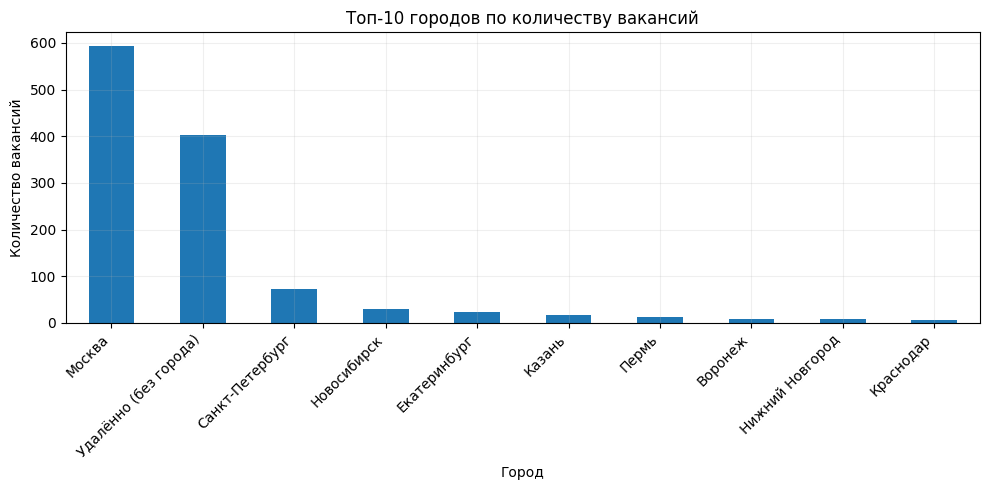

Вывод: Москва и удаленный формат сильно доминируют по числу вакансий. Остальные города дают заметно меньшую долю предложений, особенно за пределами Москвы и Санкт-Петербурга


In [82]:
# График 1: Топ-10 городов по количеству вакансий

city_counts = df["city"].value_counts().head(10)

plt.figure(figsize=(10, 5))
city_counts.plot(kind="bar")
plt.title("Топ-10 городов по количеству вакансий")
plt.xlabel("Город")
plt.ylabel("Количество вакансий")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

print("Вывод: Москва и удаленный формат сильно доминируют по числу вакансий. Остальные города дают заметно меньшую долю предложений, особенно за пределами Москвы и Санкт-Петербурга")


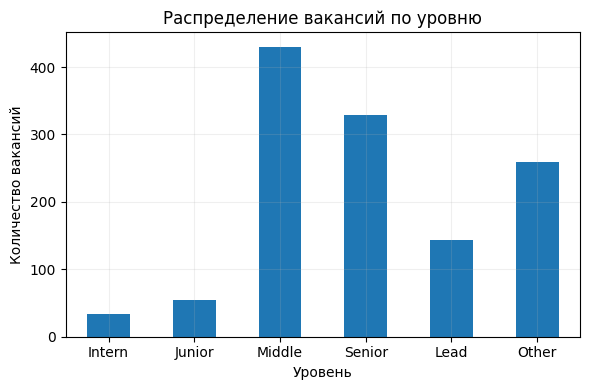

Вывод: Больше всего предложений для Middle и Senior-специалистов. Вакансий уровня Intern и Junior значительно меньше, а часть объявлений вообще не содержит явного указания уровня


In [83]:
# График 2: Распределение по уровням

level_order = ["Intern", "Junior", "Middle", "Senior", "Lead", "Other"]
level_counts = df["level"].value_counts().reindex(level_order).dropna()

plt.figure(figsize=(6, 4))
level_counts.plot(kind="bar")
plt.title("Распределение вакансий по уровню")
plt.xlabel("Уровень")
plt.ylabel("Количество вакансий")
plt.xticks(rotation=0)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print("Вывод: Больше всего предложений для Middle и Senior-специалистов. Вакансий уровня Intern и Junior значительно меньше, а часть объявлений вообще не содержит явного указания уровня")


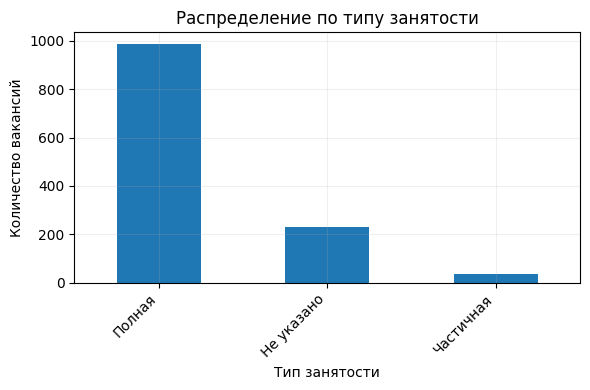

Вывод: Почти все вакансии предполагают полную занятость. Частичная занятость, стажировки и другие форматы встречаются значительно реже, у части объявлений тип занятости вообще не указан


In [84]:
# График 3: Тип занятости

employment_counts = df["employment_type"].value_counts(dropna=False)

plt.figure(figsize=(6, 4))
employment_counts.plot(kind="bar")
plt.title("Распределение по типу занятости")
plt.xlabel("Тип занятости")
plt.ylabel("Количество вакансий")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print("Вывод: Почти все вакансии предполагают полную занятость. Частичная занятость, стажировки и другие форматы встречаются значительно реже, у части объявлений тип занятости вообще не указан")


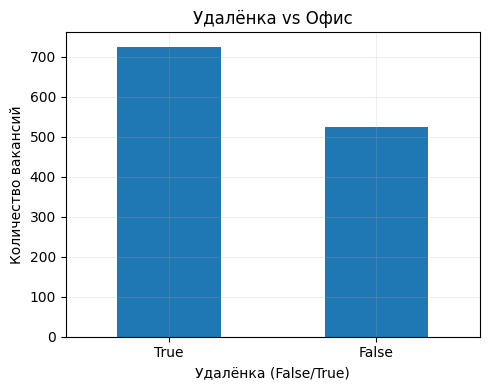

Вывод: Удалённый формат работы встречается чаще, чем чисто офисный. Тем не менее существенная часть рынка по-прежнему ориентирована на работу из офиса


In [85]:
# График 4: Удалёнка vs офис

remote_counts = df["remote_option"].value_counts()

plt.figure(figsize=(5, 4))
remote_counts.plot(kind="bar")
plt.title("Удалёнка vs Офис")
plt.xlabel("Удалёнка (False/True)")
plt.ylabel("Количество вакансий")
plt.xticks(rotation=0)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print("Вывод: Удалённый формат работы встречается чаще, чем чисто офисный. Тем не менее существенная часть рынка по-прежнему ориентирована на работу из офиса")


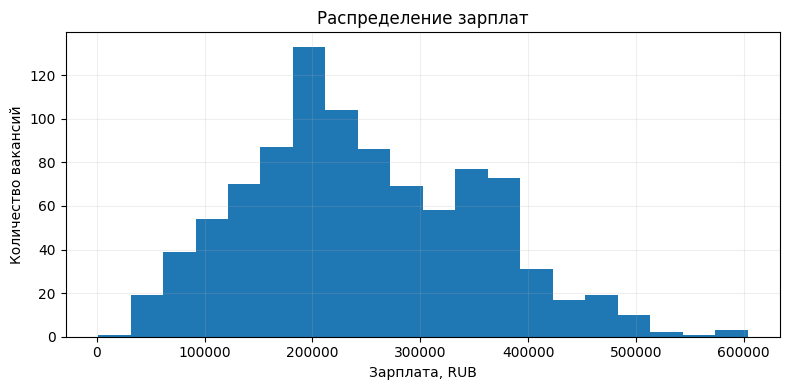

Вывод: Основная масса зарплат сосредоточена в диапазоне примерно 150–250 тыс. руб. Предложения выше 400 тыс. встречаются заметно реже и выглядят как верхняя часть распределения


In [86]:
# График 5: Распределение зарплат (RUB)

plt.figure(figsize=(8, 4))
df_rub["salary_mid"].dropna().plot(kind="hist", bins=20)
plt.title("Распределение зарплат")
plt.xlabel("Зарплата, RUB")
plt.ylabel("Количество вакансий")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print("Вывод: Основная масса зарплат сосредоточена в диапазоне примерно 150–250 тыс. руб. Предложения выше 400 тыс. встречаются заметно реже и выглядят как верхняя часть распределения")


<Figure size 800x400 with 0 Axes>

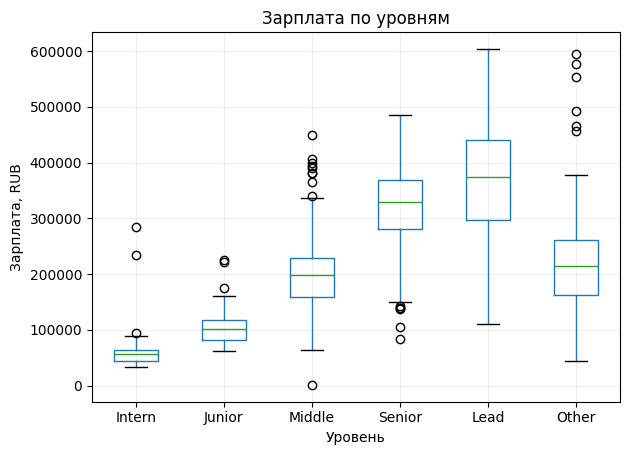

Вывод: Медианная зарплата закономерно растёт от Intern/Junior к Senior/Lead. Разброс доходов увеличивается с ростом уровня: особенно заметен диапазон зарплат у Middle, Senior и в группе Other


In [87]:
# График 6: Зарплата по уровням (boxplot)

level_order = ["Intern", "Junior", "Middle", "Senior", "Lead", "Other"]
df_rub_box = df_rub[df_rub["level"].isin(level_order)].copy()
df_rub_box["level"] = pd.Categorical(df_rub_box["level"],
                                     categories=level_order,
                                     ordered=True)

plt.figure(figsize=(8, 4))
df_rub_box.boxplot(column="salary_mid", by="level")
plt.title("Зарплата по уровням")
plt.suptitle("")
plt.xlabel("Уровень")
plt.ylabel("Зарплата, RUB")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print("Вывод: Медианная зарплата закономерно растёт от Intern/Junior к Senior/Lead. Разброс доходов увеличивается с ростом уровня: особенно заметен диапазон зарплат у Middle, Senior и в группе Other")


<Figure size 1000x400 with 0 Axes>

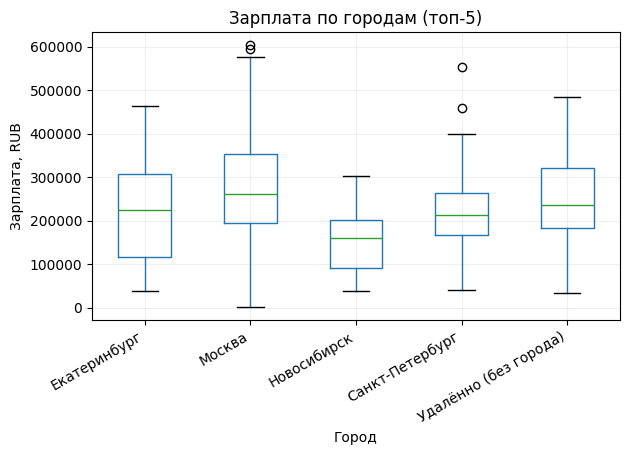

Вывод: Самые высокие медианные зарплаты предлагаются в Москве и при формате удалённо. В Санкт-Петербурге, Екатеринбурге и Новосибирске медианы ниже, при этом во всех городах разброс зарплат остаётся довольно большим


In [88]:
# График 7: Зарплата по городам (топ-5 по числу вакансий)

top_cities = df_rub["city"].value_counts().head(5).index
df_rub_top_cities = df_rub[df_rub["city"].isin(top_cities)]

plt.figure(figsize=(10, 4))  # чуть шире
df_rub_top_cities.boxplot(column="salary_mid", by="city")
plt.title("Зарплата по городам (топ-5)")
plt.suptitle("")
plt.xlabel("Город")
plt.ylabel("Зарплата, RUB")
plt.grid(alpha=0.2)
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()

print("Вывод: Самые высокие медианные зарплаты предлагаются в Москве и при формате удалённо. В Санкт-Петербурге, Екатеринбурге и Новосибирске медианы ниже, при этом во всех городах разброс зарплат остаётся довольно большим")

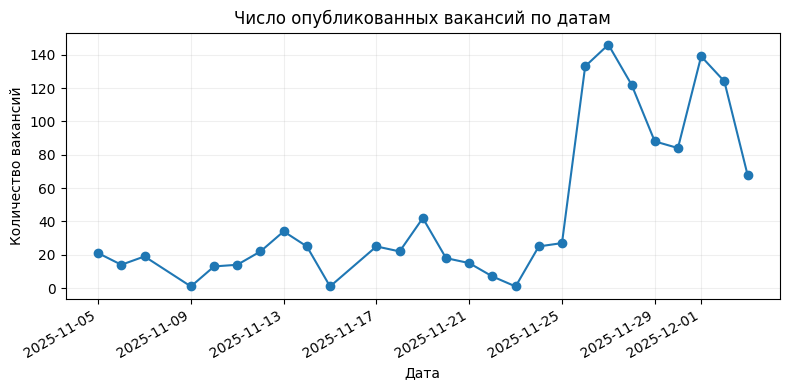

Вывод: если период длинный, можно увидеть тренды (рост/падение спроса).


In [73]:
# График 8: Динамика числа вакансий по датам

vac_per_date = df.groupby("date_posted_timestamp")["id"].count()

plt.figure(figsize=(8, 4))
vac_per_date.plot(kind="line", marker="o")
plt.title("Число опубликованных вакансий по датам")
plt.xlabel("Дата")
plt.ylabel("Количество вакансий")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print("Вывод: в начале периода количество вакансий колеблется на относительно низком уровне, затем к концу наблюдается заметный всплеск публикаций, что может отражать рост спроса в рассматриваемый промежуток времени.")


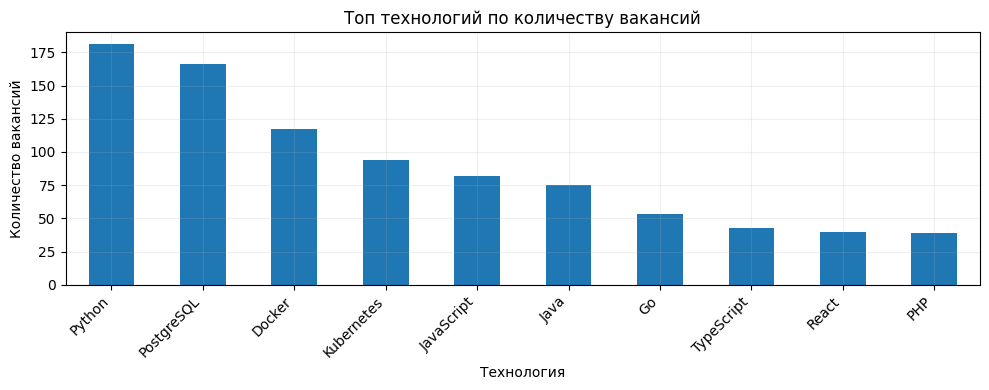

Вывод: Чаще всего работодатели ищут специалистов с навыками Python, PostgreSQL и Docker. Kubernetes и JavaScript также востребованы, в то время как React, PHP и TypeScript появляются в объявлениях заметно реже


In [89]:
# График 9: Топ технологий по количеству вакансий

tech_counts = {}
for tech in techs:
    col = tech_col_name(tech)
    tech_counts[tech] = df[col].sum()

tech_series = pd.Series(tech_counts).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 4))
tech_series.plot(kind="bar")
plt.title("Топ технологий по количеству вакансий")
plt.xlabel("Технология")
plt.ylabel("Количество вакансий")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print("Вывод: Чаще всего работодатели ищут специалистов с навыками Python, PostgreSQL и Docker. Kubernetes и JavaScript также востребованы, в то время как React, PHP и TypeScript появляются в объявлениях заметно реже")


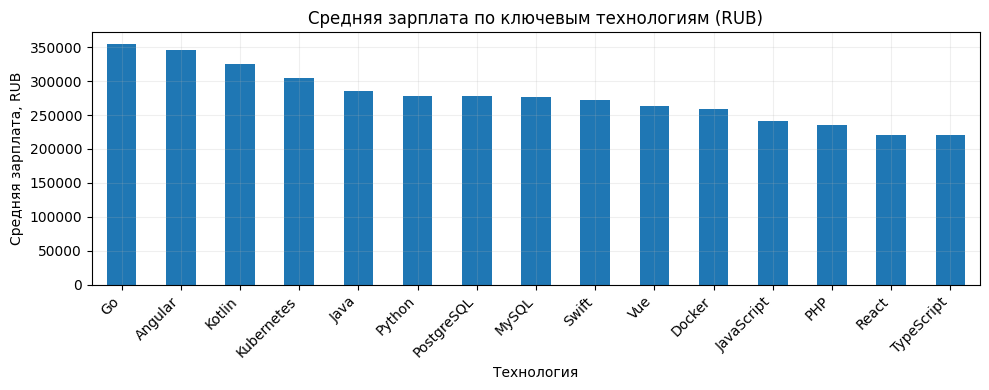

Вывод: Наиболее высокие средние зарплаты связаны с Go, Angular, Kotlin и Kubernetes. Стек вокруг Java/Python также выглядит сильным, тогда как фронтенд-технологии, PHP, React и TypeScript в среднем оплачиваются заметно ниже


In [90]:
# График 10: Средняя зарплата по ключевым технологиям (RUB)

avg_salary_by_tech = {}
for tech in techs:
    col = tech_col_name(tech)
    mask = (df_rub[col]) & df_rub["salary_mid"].notna()
    if mask.sum() >= 5:  # чтобы не считать по единичным вакансиям
        avg_salary_by_tech[tech] = df_rub.loc[mask, "salary_mid"].mean()

if avg_salary_by_tech:
    tech_salary_series = pd.Series(avg_salary_by_tech).sort_values(ascending=False)

    plt.figure(figsize=(10, 4))
    tech_salary_series.plot(kind="bar")
    plt.title("Средняя зарплата по ключевым технологиям (RUB)")
    plt.xlabel("Технология")
    plt.ylabel("Средняя зарплата, RUB")
    plt.xticks(rotation=45, ha="right")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    print("Вывод: Наиболее высокие средние зарплаты связаны с Go, Angular, Kotlin и Kubernetes. Стек вокруг Java/Python также выглядит сильным, тогда как фронтенд-технологии, PHP, React и TypeScript в среднем оплачиваются заметно ниже")



In [91]:
# Экспорт подготовленного датасета для DataLens
df.to_csv("vacancies_prepared.csv", index=False)
